<h1>CatBoostClassifier with shipping dataset<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

An international e-commerce company based wants to discover key insights from their customer database. They want to use some of the most advanced machine learning techniques to study their customers. The company sells electronic products.

In [305]:
import pandas as pd
import polars as pl
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=4)
import catboost
import sklearn
import shap

from catboost import CatBoostClassifier
from catboost import MetricVisualizer
from catboost import cv
from catboost import * 
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve
from catboost.utils import select_threshold

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

**Data upload:**

In [306]:
df = pd.read_csv('../shipping.csv')

In [307]:
display(df.head(5), df.shape)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


(10999, 12)

- ID: ID Number of Customers.

- Warehouse block: The Company have big Warehouse which is divided in to block such as A,B,C,D,E.

- Mode of shipment:The Company Ships the products in multiple way such as Ship, Flight and Road.

- Customer care calls: The number of calls made from enquiry for enquiry of the shipment.

- Customer rating: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).

- Cost of the product: Cost of the Product in US Dollars.

- Prior purchases: The Number of Prior Purchase.

- Product importance: The company has categorized the product in the various parameter such as low, medium, high.

- Gender: Male and Female.

- Discount offered: Discount offered on that specific product.

- Weight in gms: It is the weight in grams.

- **Reached on time:** It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time.

In [308]:
df.columns = [c.lower().replace(' ', '_') for c in df.columns]

In [309]:
df.head(5)

,id,warehouse_block,mode_of_shipment,customer_care_calls,customer_rating,cost_of_the_product,prior_purchases,product_importance,gender,discount_offered,weight_in_gms,reached.on.time_y.n
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [310]:
df.duplicated().sum()

0

In [311]:
df['reached.on.time_y.n'].value_counts()

reached.on.time_y.n
1    6563
0    4436
Name: count, dtype: int64

In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   10999 non-null  int64 
 1   warehouse_block      10999 non-null  object
 2   mode_of_shipment     10999 non-null  object
 3   customer_care_calls  10999 non-null  int64 
 4   customer_rating      10999 non-null  int64 
 5   cost_of_the_product  10999 non-null  int64 
 6   prior_purchases      10999 non-null  int64 
 7   product_importance   10999 non-null  object
 8   gender               10999 non-null  object
 9   discount_offered     10999 non-null  int64 
 10  weight_in_gms        10999 non-null  int64 
 11  reached.on.time_y.n  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [313]:
X = df.drop(['id', 'reached.on.time_y.n'], axis=1)
y = df['reached.on.time_y.n']

In [314]:
cat = X.select_dtypes(exclude='number').columns.tolist()
cat_features_index = []
for c in cat:
    cat_features_index.append(X.columns.get_loc(c))

In [315]:
cat_features = X.select_dtypes(exclude='number').columns.tolist()

In [316]:
display(cat_features, cat_features_index)

['warehouse_block', 'mode_of_shipment', 'product_importance', 'gender']

[0, 1, 6, 7]

In [317]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Models learning:**

Learning with two parameters:

- iterations qty

- learning rate

In [318]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.15
)

In [319]:
model.fit(X_train, y_train,
         cat_features=cat_features,
         eval_set=(X_test, y_test),
          verbose=False
)

print(f'Model is fitted: {str(model.is_fitted())}')
print(f'Model params: {model.get_params()}')

Model is fitted: True
Model params: {'iterations': 100, 'learning_rate': 0.15}


If select Verbose equal to 10, it means that, every 10 iterations will be printed progress of learning:

In [320]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.15
)

model.fit(X_train, y_train,
         cat_features=cat_features,
         eval_set=(X_test, y_test),
         verbose=10
)

0:	learn: 0.6589590	test: 0.6596336	best: 0.6596336 (0)	total: 3.66ms	remaining: 362ms
10:	learn: 0.5350643	test: 0.5402873	best: 0.5402873 (10)	total: 36.5ms	remaining: 296ms
20:	learn: 0.5075625	test: 0.5167640	best: 0.5167640 (20)	total: 68.1ms	remaining: 256ms
30:	learn: 0.4986844	test: 0.5110256	best: 0.5109842 (29)	total: 113ms	remaining: 251ms
40:	learn: 0.4959850	test: 0.5094047	best: 0.5094047 (40)	total: 151ms	remaining: 218ms
50:	learn: 0.4936894	test: 0.5092005	best: 0.5091914 (47)	total: 180ms	remaining: 173ms
60:	learn: 0.4917270	test: 0.5086342	best: 0.5086342 (60)	total: 211ms	remaining: 135ms
70:	learn: 0.4895782	test: 0.5082193	best: 0.5080183 (67)	total: 246ms	remaining: 100ms
80:	learn: 0.4868417	test: 0.5078294	best: 0.5078294 (80)	total: 295ms	remaining: 69.1ms
90:	learn: 0.4844421	test: 0.5072397	best: 0.5072397 (90)	total: 343ms	remaining: 33.9ms
99:	learn: 0.4838575	test: 0.5072416	best: 0.5072169 (97)	total: 385ms	remaining: 0us

bestTest = 0.5072169087
bestIt

As result we can see bestIteration and bestTest metric

With parameter custom_loss we can use other metrics, for example: 'AUC', 'Accuracy'. Also parameter Plot, with flag True what will show real-time process of learning: 

In [321]:
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.15,
    custom_loss=['AUC', 'Accuracy']
)

model.fit(X_train, y_train,
         cat_features=cat_features,
         eval_set=(X_test, y_test),
          verbose=False,
          plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

The point on the graph shows moment when our model was overtrained.

Test models with different learning_rate: 0.7 and 0.01:

In [322]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    random_seed=40,
    train_dir='learning_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    random_seed=40,
    train_dir='learning_rate_0.01'
)

model1.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features,
    verbose=False
)

model2.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features,
    verbose=False
)

In [323]:
MetricVisualizer(['learning_rate_0.01', 'learning_rate_0.7']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

There we can see what model with a learning_rate of 0.7 immediately received overtraining and model with a learning_rate of 0.01 received overtraining in the last iterations, based on this, we can say that the last model is of higher quality.

Parameter use_best_model allows you to discard unnecessary trees, by default it is enabled as True:

In [324]:
model = CatBoostClassifier(
    iterations=500,
    random_seed=40,
    learning_rate=0.15
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True, 
    use_best_model=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [325]:
print(f'Tree count: {str(model.tree_count_)}')

Tree count: 67


**Usage of Cross Validation:**

In [326]:
params = {
    'loss_function': 'Logloss',
    'iterations': 50,
    'custom_loss': 'AUC',
    'random_seed': 43,
    'learning_rate': 0.5
}

cv_data = cv(
    params=params,
    pool=Pool(X, label=y, cat_features=cat_features),
    fold_count=5, # split of 5 parts
    shuffle=True, # mix of data
    partition_random_seed=33,
    plot=True, 
    stratified=True, 
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5024189404
bestIteration = 4

Training on fold [1/5]

bestTest = 0.4997459553
bestIteration = 6

Training on fold [2/5]

bestTest = 0.5005651338
bestIteration = 12

Training on fold [3/5]

bestTest = 0.5128649038
bestIteration = 19

Training on fold [4/5]

bestTest = 0.5113112807
bestIteration = 2



In [327]:
cv_data.head(5) # results of Cross Validation

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.532112,0.007079,0.531020,0.002373,0.729199,0.015374
1,1,0.513202,0.006570,0.511016,0.004884,0.741338,0.006715
2,2,0.509368,0.005584,0.505150,0.004162,0.745168,0.009009
3,3,0.508720,0.006214,0.503310,0.004063,0.745258,0.009470
4,4,0.508731,0.005523,0.501840,0.003491,0.742998,0.008627


In [328]:
best_value = np.max(cv_data['test-AUC-mean'])
best_iter = np.argmax(cv_data['test-AUC-mean'])
print('Best validation AUC score, stratified: {:.4f}+/-{:.3f} on step {}'.format(
best_value, cv_data['test-AUC-std'][best_iter], best_iter))

Best validation AUC score, stratified: 0.7453+/-0.009 on step 3


When the early_stopping_rounds parameter is added, which in this case is equal to 20; if over the course of 20 iterations the error on the validation set worsens, then training will be stopped:

In [329]:
model_with_early_stop = CatBoostClassifier(
    iterations=100,
    random_seed=33,
    learning_rate=0.3,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [330]:
print(model_with_early_stop.tree_count_)

70


In [331]:
model_with_early_stop=CatBoostClassifier(
    eval_metric='AUC', # select metric and print in first order
    iterations=100,
    random_seed=43,
    learning_rate=0.3,
    early_stopping_rounds=20)
model_with_early_stop.fit(
    X_train,y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [332]:
print(model_with_early_stop.tree_count_)

8


We can see that overtraining occurred at iteration 8, another 20 passed and training was stopped:

get_roc_curve function, it returns us the ROC curve (true positive rate, false positive rate and thresholds):

In [333]:
eval_pool = Pool(X_test, y_test, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

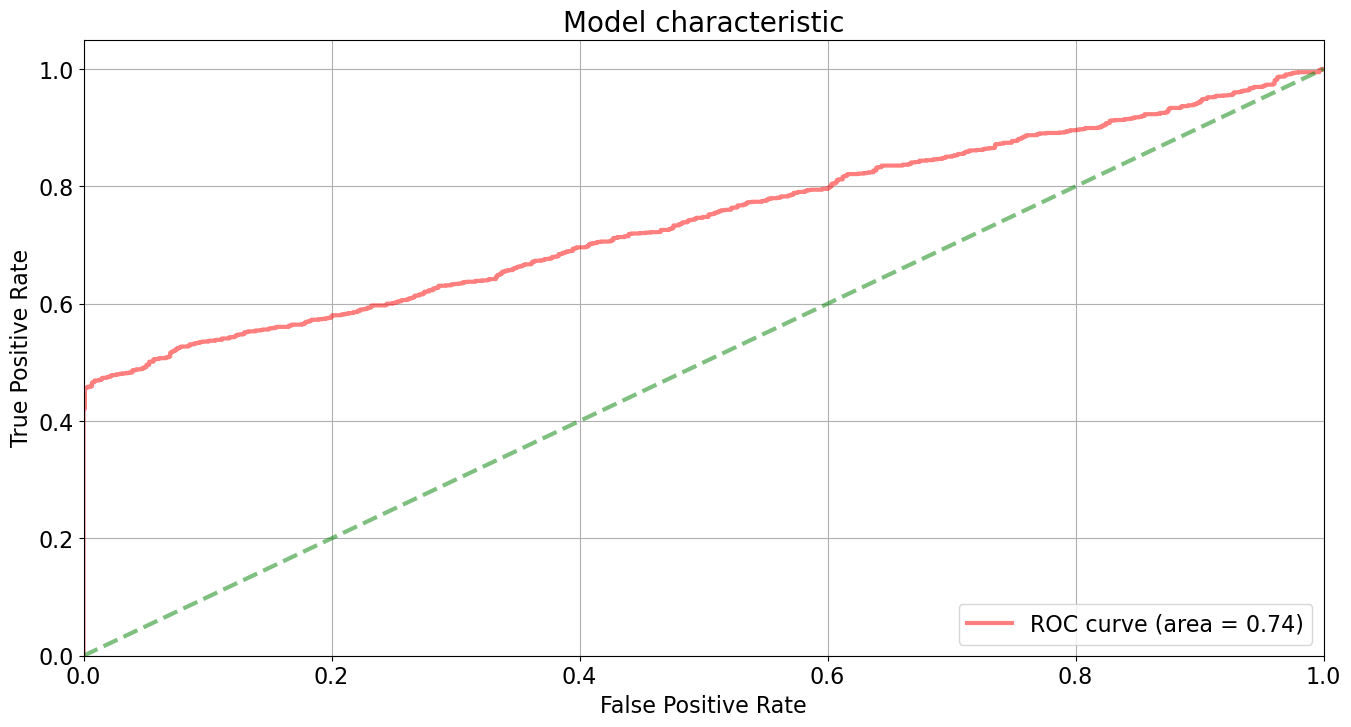

In [334]:
plt.figure(figsize=(16, 8))
lw=3

plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='g', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Model characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

**Calculation of: FPR, FNR и THRESHOLD**

In [335]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

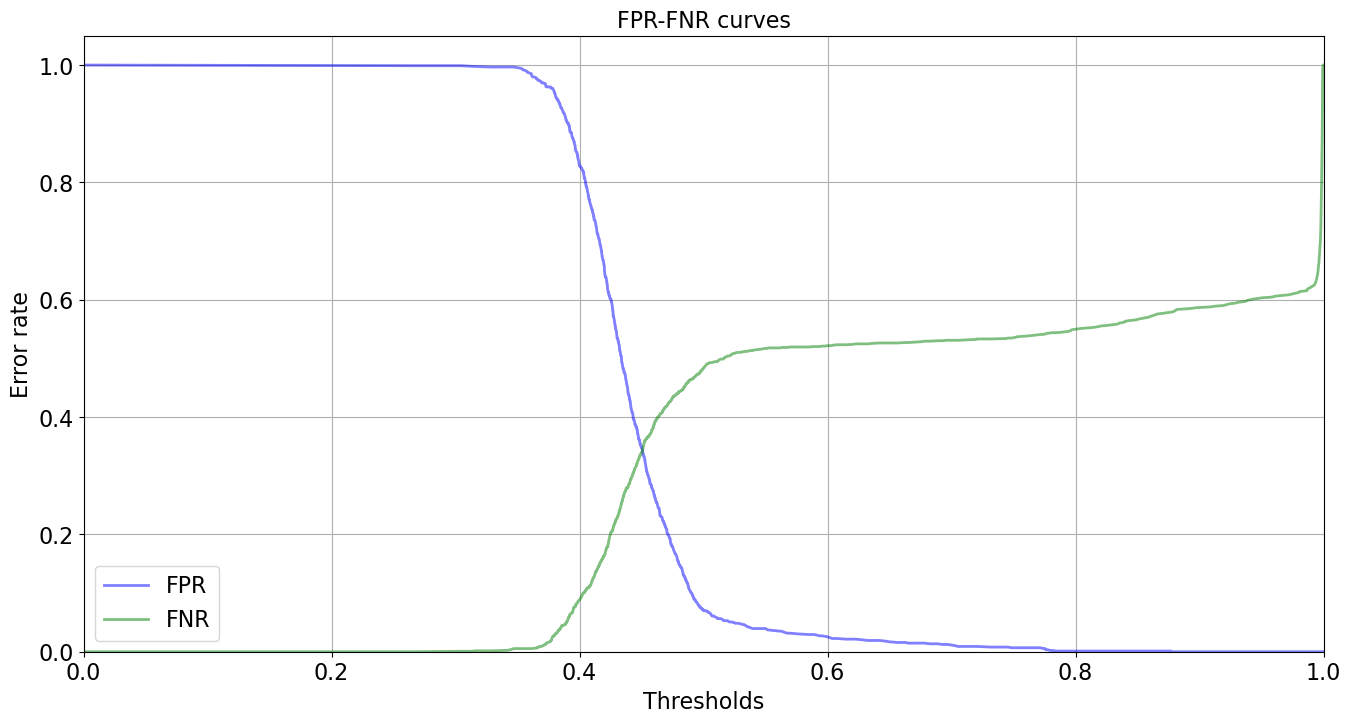

In [336]:
plt.figure(figsize=(16, 8))
lw=2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Thresholds', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
plt.show()

To determine the optimal limit on the graph, we will use select_threshold:

In [337]:
print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.3701940245396863
0.7050939674458603


In [339]:
print(model.predict_proba(X_test))

[[1.5848e-03 9.9842e-01]
 [4.9840e-01 5.0160e-01]
 [6.3059e-01 3.6941e-01]
 ...
 [5.8379e-01 4.1621e-01]
 [5.3793e-01 4.6207e-01]
 [8.7925e-04 9.9912e-01]]


In [340]:
print(model.predict(X_test))

[1 1 0 ... 0 0 1]


If we forgot to specify some metrics when training the model, or after training we want to calculate the values of metrics on a data set that has not been used before, in this case can use eval_metrics:

In [345]:
model = CatBoostClassifier(
    random_seed=53,
    iterations=100,
    learning_rate=0.05
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=10
)

0:	learn: 0.6804697	total: 4.58ms	remaining: 453ms
10:	learn: 0.6024621	total: 38.1ms	remaining: 308ms
20:	learn: 0.5607595	total: 72ms	remaining: 271ms
30:	learn: 0.5370981	total: 105ms	remaining: 234ms
40:	learn: 0.5228475	total: 140ms	remaining: 202ms
50:	learn: 0.5139753	total: 172ms	remaining: 166ms
60:	learn: 0.5078130	total: 198ms	remaining: 127ms
70:	learn: 0.5048753	total: 230ms	remaining: 93.9ms
80:	learn: 0.5027478	total: 262ms	remaining: 61.4ms
90:	learn: 0.5007295	total: 286ms	remaining: 28.3ms
99:	learn: 0.4994866	total: 305ms	remaining: 0us


In [346]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)

In [347]:
metrics = model.eval_metrics(
    data= pool1,
    metrics= ['Logloss', 'AUC'],
    ntree_start= 0,
    ntree_end= 0,
    eval_period= 1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [350]:
print(f'AUC values: \n {np.array(metrics["AUC"])}')

AUC values: 
 [0.74   0.7423 0.7497 0.7515 0.7527 0.7533 0.754  0.7541 0.7556 0.7557
 0.7559 0.7564 0.7568 0.7572 0.7572 0.7579 0.7581 0.7585 0.7587 0.7583
 0.7583 0.7584 0.7594 0.7593 0.7593 0.7596 0.7607 0.7608 0.7616 0.7618
 0.7621 0.7621 0.7622 0.7624 0.7623 0.7622 0.7627 0.7628 0.7625 0.7625
 0.7627 0.7628 0.7629 0.7635 0.7634 0.764  0.764  0.764  0.7643 0.7649
 0.7649 0.7655 0.7657 0.7659 0.7661 0.7669 0.7673 0.7674 0.7675 0.7675
 0.7676 0.7681 0.7688 0.7686 0.769  0.769  0.7694 0.7695 0.7696 0.7701
 0.7706 0.7707 0.7707 0.7712 0.7716 0.7716 0.7718 0.7723 0.7723 0.7724
 0.7727 0.7727 0.7728 0.7732 0.7734 0.7733 0.7733 0.7734 0.7738 0.774
 0.774  0.7741 0.7751 0.7752 0.7752 0.7751 0.7752 0.7751 0.7752 0.7755]


**Show importances features:**

In [351]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,discount_offered,59.915972
1,weight_in_gms,21.765086
2,prior_purchases,6.490458
3,cost_of_the_product,5.118964
4,customer_care_calls,2.733738
5,customer_rating,1.623736
6,product_importance,0.784494
7,gender,0.735237
8,mode_of_shipment,0.536656
9,warehouse_block,0.295660


In [352]:
shap_values=model.get_feature_importance(pool1, fstr_type='ShapValues')
print(shap_values.shape)

(10999, 11)


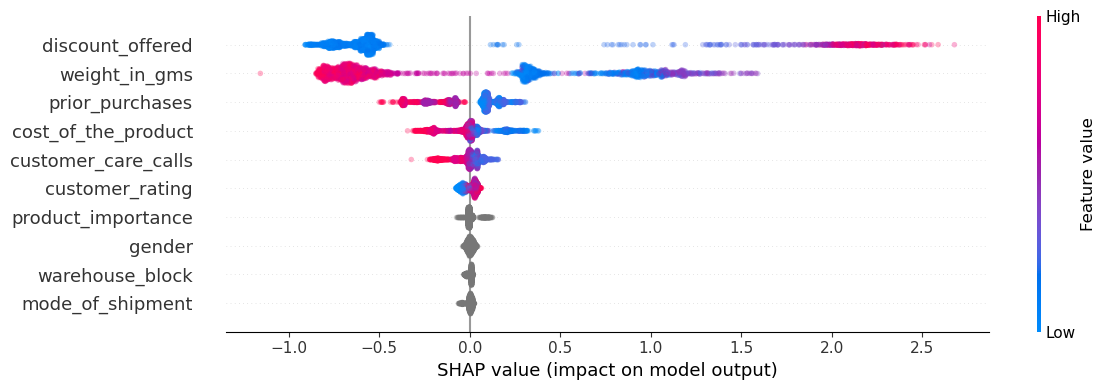

In [378]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)

shap.summary_plot(shap_test, X_test,
                 max_display=12, plot_size=[12,4],
                  alpha=0.3
                 )

In [354]:
explainer = shap.TreeExplainer(model)
shap_values=explainer.shap_values(Pool(X, y, cat_features=cat_features))

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[110,:], X.iloc[110,:])

1. If greater the **weight_in_gms**, the greater the probability of belonging to class 0 (product has reached on time, if smaller **the weight_in_gms**, the greater the probability of belonging to class 1 (product has NOT reached on time)

2. If greater the **discount_offered**, the greater the probability of belonging to class 1 (product has NOT reached on time)

3. If greater the **prior_purchases**, the greater the probability of belonging to class 0 (product has reached on time)